In [11]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

from pyro.nn import PyroSample

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(1)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [4]:
#MCMC Sampling Function

####
#MCMC(kernel, num_samples, warmup_steps=None, initial_params=None, num_chains=1, hook_fn=None, mp_context=None, disable_progbar=False, disable_validation=True, transforms=None
#Kernel is of Tracekernel Class, which takes in a trace and outputs a trace from the posterior distribution. 

#Num_Chains is is number of MCMC chains to run in parallel. 

#Initial_params is initial tensors to initiate the markov chain. 


#
    
    
     
#####

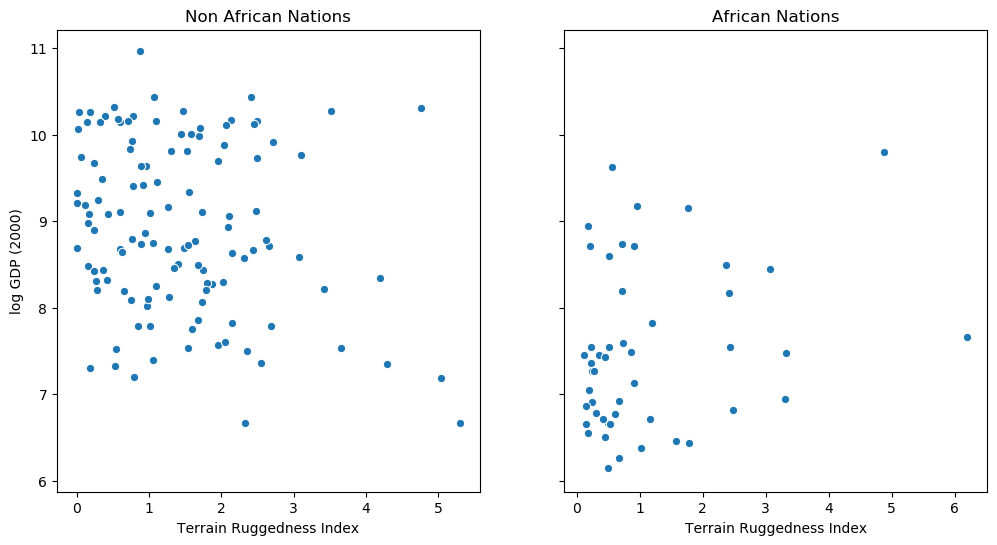

In [9]:
#Bayesian Regressoin Example


#Data Set up and Visualization
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");


In [10]:
#We want to learn linear parameter of class NN.Parameter, weight and bias are of NN.Linear Class. 

#When declared inside a PyroModule as attributes, these are automatically registered in Pyro’s param store.


from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)


In [12]:
#Create Bayesian Models. 

#First, we require having a prior distribution on parameters w and b, using PyroSample. 


class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        #Linear layer with in_feature and out_feature, only modifies last dimension
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        
        #Prior Distributions on the Weight and Bias variables, expands to the out_features and in_features.
        
        #To_event declares n dimensions from the right as 'dependent'.
        
        
        #To_event(2) since event_shape should be 2 dimensional 
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        
        
        #To_Event(1) since event shape should be 1 dimensional
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))
        
        
        #Important, to_event(1) declares the dimension as 'Dependent'. 
        #to_event(2) declares the dimension as 

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]): #Declare first dimension as independent.
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

    
    
    #Create Kernel in Pyro on the conditioned Model
    nuts_kernel = pyro.infer.NUTS(conditioned_model, adapt_step_size=True)

    
    #Utilize MCMC Sampling to find the posterior points. 
    hmc_posterior = pyro.infer.MCMC(nuts_kernel,
    num_samples=1000,
    warmup_steps=200)

    #Then we run this hmc_posterior on our data set to get the posterior distribution. 


In [27]:
#Understanding Tensor Shapes

#.batch_shape are conditionally independent random variables. 

#event_shape are DEPENDENT random variables, i.e. drawing from the same distribution. 

#.log_prob has same shape as batch_shape. Since the probability gets defined together. 

#Distributions.sample() takes a sample_Shape to create that number of IID samples. 

#shape = sample_shape + batch_shape + event_shape

#Univariate distributions have empty event shape, as each number is completely independent. 
#Distributions over vectors have shape 1, while distributions over matrices have shape 2. 
from pyro.distributions import Bernoulli, Categorical, MultivariateNormal, Normal
d = Bernoulli(0.7 * torch.ones(3,4))

x = d.sample()

print(x)

print(d.log_prob(x)) #Computes the log probability of that event happening. 






tensor([[1., 1., 0., 1.],
        [0., 1., 1., 1.],
        [0., 0., 1., 1.]])
tensor([[-0.3567, -0.3567, -1.2040, -0.3567],
        [-1.2040, -0.3567, -0.3567, -0.3567],
        [-1.2040, -1.2040, -0.3567, -0.3567]])


In [ ]:
#Multivariate Distribution

d = MultivariateNormal(torch.zeros(3), torch.eye(3, 3))
assert d.batch_shape == ()
assert d.event_shape == (3,)
x = d.sample()
assert x.shape == (3,)            # == batch_shape + event_shape
assert d.log_prob(x).shape == ()  # == batch_shape

#Try to think of batch_shape as number of samples, while event_shape is the variables in one sample, and thus dependent. 


In [ ]:
#Understanding pyro.plate 